In [46]:
import argparse
import os
import time

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from flamby.datasets.fed_tcga_brca import (
    BATCH_SIZE,
    LR,
    NUM_EPOCHS_POOLED,
    Baseline,
    BaselineLoss,
    FedTcgaBrca,
    NUM_CLIENTS,
    metric,
    get_nb_max_rounds,
    EnhancedModel
)
from flamby.utils import evaluate_model_on_tests
import warnings
import warnings
warnings.filterwarnings("ignore")
from flamby.datasets.fed_tcga_brca import FedTcgaBrca as FedDataset
from flamby.strategies.fed_avg_log import FedAvgWithLog as strat
from tqdm import tqdm
from flamby.utils import evaluate_model_on_tests
train_dataloaders = [
            torch.utils.data.DataLoader(
                FedDataset(center = i, train = True, pooled = False),
                batch_size = BATCH_SIZE,
                shuffle = True,
                num_workers = 0
            )
            for i in range(NUM_CLIENTS)
        ]

lossfunc = BaselineLoss()
m = Baseline()
# Federated Learning loop
# 2nd line of code to change to switch to another strategy (feed the FL strategy the right HPs)
args = {
            "training_dataloaders": train_dataloaders,
            "model": m,
            "loss": lossfunc,
            "optimizer_class": torch.optim.Adam,
            "learning_rate": LR / 50.0,
            "num_updates": 40,
# This helper function returns the number of rounds necessary to perform approximately as many
# epochs on each local dataset as with the pooled training
            "nrounds": get_nb_max_rounds(40),
        }

In [47]:
s = strat(**args)
results = []

for client_id in range(NUM_CLIENTS):
    test_dataset = FedTcgaBrca(center=client_id, train=False, pooled=False)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        drop_last=False,
    )
    results.append((client_id,evaluate_model_on_tests(s.models_list[client_id].model, [test_dataloader], metric, use_tqdm=False)))
for rounds in tqdm(range(60)):
    s.perform_round()

    if (rounds+1) % 2 == 0: 
    # evaluation for clients
        for client_id in range(NUM_CLIENTS):
            test_dataset = FedTcgaBrca(center=client_id, train=False, pooled=False)
            test_dataloader = torch.utils.data.DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=4,
                drop_last=False,
            )
            results.append((client_id,evaluate_model_on_tests(s.models_list[client_id].model, [test_dataloader], metric, use_tqdm=False)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:01<00:00,  1.02s/it]


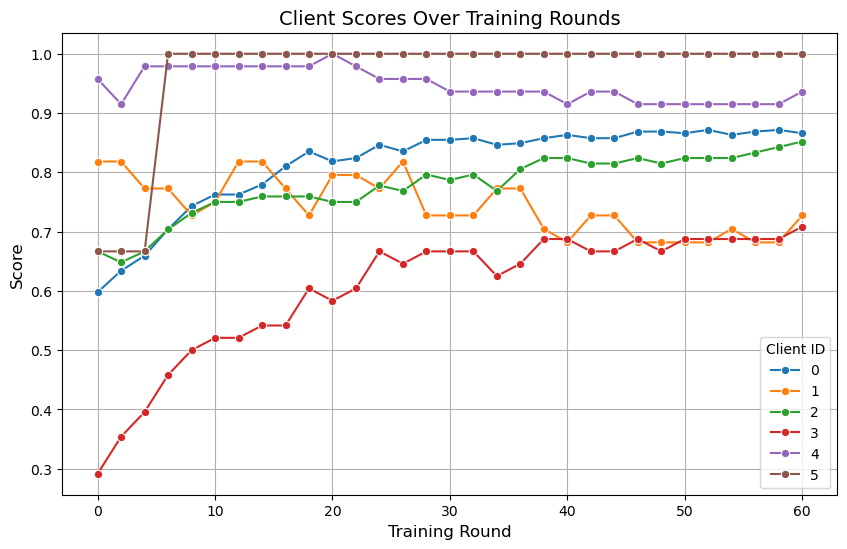

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 按组整理数据（6个一组）
grouped_data = []
group_size = 6
for i in range(0, len(results), group_size):
    group = results[i:i + group_size]
    grouped_data.append(group)

# 转换为适合绘图的数据格式
data = []
for group_idx, group in enumerate(grouped_data):
    for client_id, score_data in group:
        data.append({
            'Training Round': (group_idx) * 2,
            'Client ID': client_id,
            'Score': score_data['client_test_0']
        })

# 创建 DataFrame
df = pd.DataFrame(data)

# 使用 seaborn 绘图
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Training Round', y='Score', hue='Client ID', marker='o', palette='tab10')

# 添加标题和标签
plt.title('Client Scores Over Training Rounds', fontsize=14)
plt.xlabel('Training Round', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Client ID')
plt.grid(True)
plt.show()
